In [1]:
''' 
datecreated: 190811
objective: work on creating a depth-first search and breadth-first search 
    example here, then transferring back to a python script. using jupyter 
    notebook because of it's rapid prototyping capability
'''

import numpy as np
import matplotlib.pyplot as plt
import time

# setup functions
def plotgrid(gridarr,start,end,fsize=4):
    ''' ensure that plot comes out nicely formatted '''
    nrows,ncols = gridarr.shape    
    f,p=plt.subplots(figsize=[fsize]*2)
    p.imshow(gridarr,cmap='gray')
    xticks=np.arange(0,ncols+1)-0.5
    yticks=np.arange(0,nrows+1)-0.5
    xlims=[xticks.min(),xticks.max()]
    ylims=[yticks.min(),yticks.max()]
    p.set_xticks(xticks,minor=True)
    p.set_yticks(yticks,minor=True)
    p.grid(b=True,which='minor')
    p.plot(*start[::-1],'ro')
    p.plot(*end[::-1],'rx')
    return f,p

def canGoInDir(arr,coord,direction):
    ''' 
    create a map that says whether a point can go in a given direction. 
        alternative to making a tree in the typical sense. 
        only works with orthogonal directions (no diagonals coded here)
    '''
    row,col=coord
    if(direction==0):
        # check if can go 'up'
        if(row==0): return False # at top row
        elif(arr[row-1,col]==0): return False # occupied
        else: return True
    elif(direction==1): 
        # check if can go 'right'
        if(col==arr.shape[1]-1): return False # at right-most column
        elif(arr[row,col+1]==0): return False # occupied
        else: return True
    elif(direction==2): 
        # check if can go 'down'
        if(row==arr.shape[0]-1): return False # at bottom row
        elif(arr[row+1,col]==0): return False # occupied
        else: return True
    elif(direction==3):
        # check if can go 'left'
        if(col==0): return False # at left-most column 
        elif(arr[row,col-1]==0): return False # occupied
        else: return True
    else: print('error: not a valid direction')

def coord2cellnum(coord,gridwidth):
    ''' assume coordinate is (row,col) '''
    return coord[0]*gridwidth+coord[1]
def cellnum2coord(num,gridwidth):
    i=1
    while(i*gridwidth<=num):i+=1
    i-=1
    return [i,num-i*gridwidth]
def makeAdjList(arr):
    ''' create adjacency list '''
    adjList = dict()
    w=arr.shape[1]
    for i,irow in enumerate(arr):
        for j,jcol in enumerate(irow):
            if(arr[i,j]!=0):
                # not empty
                ilist = []
                if(canGoInDir(arr,[i,j],0)): ilist.append((i-1)*w+j) # can go up
                if(canGoInDir(arr,[i,j],1)): ilist.append(i*w+(j+1)) # right
                if(canGoInDir(arr,[i,j],2)): ilist.append((i+1)*w+j) # down
                if(canGoInDir(arr,[i,j],3)): ilist.append(i*w+(j-1)) # left
                cellNo = int(i*arr.shape[1]+j)
                adjList[cellNo] = ilist
    return adjList
def path2coords(pathlist,gridwidth):
    w=gridwidth;coords = []
    for ipoint in pathlist:
        coords.append( cellnum2coord(ipoint,w) )
    return coords


In [2]:
''' create a desired map and generate accompanying adjacency list '''

# grid 1
grid=np.ones((4,4))
grid[1,2]=0
grid[2,2]=0
loc_start = [0,0]
loc_end   = [3,3]

# grid 2
grid = np.ones((2,2))
loc_start = [0,0]
loc_end   = [1,1]
grid[0,1] = 0

# grid 3
grid = np.ones((3,3))
grid[1,2]=0
loc_start = [0,0]
loc_end   = [2,2]

# grid 4 (dungeon problem grid)
grid = np.ones((5,7))
grid[0,3]=0
grid[1,1]=0
grid[1,5]=0
grid[2,1]=0
grid[3,2]=0
grid[3,3]=0
grid[4,0]=0
grid[4,2]=0
grid[4,5]=0
loc_start=[0,0]
loc_end  =[4,3] # row/col format

print('map created')

w=grid.shape[1]
st = coord2cellnum(loc_start,w)
en = coord2cellnum(loc_end,w)
print('start / end points created')

adj=makeAdjList(grid)
print('adjacency list created')

map created
start / end points created
adjacency list created


[0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]
mms: 0.0


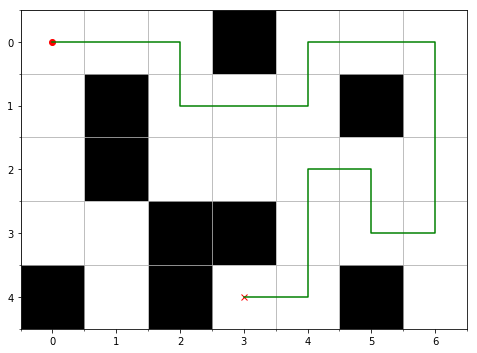

In [9]:
''' alright, with an adjancency list now created, will iterate through each 
    node (number) '''
def dfs(_adjlist,curr,goal,_path=None):
    ''' depth-first search. runs recursively. note: need to simplify this code and understand better. '''
    status=False
    if(_path==None):
        _path = []
    _path.append(curr)
    if(curr==goal):
        return True,_path
    else:
        for ioption in _adjlist[curr]: 
            if(ioption not in _path):
                status,_path = dfs(_adjlist,ioption,goal,_path)
                if(status==True):
                    return status,_path
                elif(len(_path)>0):
                    _path.pop(-1) # remove incorrect paths
    return status,_path

t0=time.time()
path = dfs(adj,st,31)[1]
print(path)
print('mms:',(time.time()-t0)*1000000)

coords=np.array(path2coords(path,grid.shape[1]))
x=coords[:,1]
y=coords[:,0]
f,p=plotgrid(grid,loc_start,loc_end,8)

p.plot(x,y,'g-')


solved!
prev loc: 32
[0, 1, 2, 9, 10, 11, 18, 25, 32, 31]
mms: 0.0


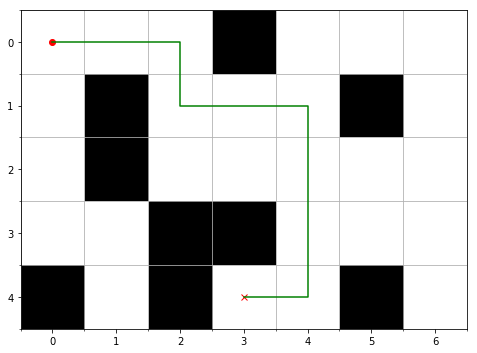

In [10]:
''' bfs with some kind of tracking '''
# version1: just see if you can find a solution

def bfs(_adjlist,options,goal,history=None,oldoptions=None):
    ''' simple attempt at bfs. added "history" to properly keep track of where things have been 
    INPUTS: 
        * _adjlist: adjacency list. essentially a list of new available paths
        * options: starting location. internally, list of current options
        * goal: end point to reach.
    '''
    if(type(options)!=list):
        # first iteration
        history=[options] # prevent infinite loops
        options=[options] # aka current location
    else:
        history+=options
    newoptions=[]
    prevoptions=[]
    for i,ioption in enumerate(options): # for each currently known option...
        if(ioption==goal):
            print('solved!')
            print('prev loc:',oldoptions[i])
            return [ioption] # return solution
        # while generating new paths, remember old ones
        for inew in _adjlist[ioption]:
            if(inew not in history):
                newoptions.append(inew)
                prevoptions.append(ioption)
    if(len(newoptions)>0):
        # can continue
        path = bfs(_adjlist,newoptions,goal,history.copy(),prevoptions.copy())
        # if a solution is found, path represents correct item in newoptions
        # finding the index of that option leads to the right previous option
        iloc=newoptions.index(path[0])
        path.insert(0,prevoptions[iloc])
        return path
    else:
        print('no solution found')
        return None

t0=time.time()
path = bfs(adj,st,en)
print(path)
print('mms:',(time.time()-t0)*1000000)

coords=np.array(path2coords(path,w))
f,p=plotgrid(grid,loc_start,loc_end,8)
p.plot(coords[:,1],coords[:,0],'g-')


In [105]:
''' shit, might actually need to do dfs improvement before moving on. '''

def dfs2(_adjlist,curr,goal,path=None,iter1=True):
    ''' second attempt at more elegant dfs. remember: key is backtracking '''
    if(type(path)==type(None)):
        # first iteration
        path=[]

    path.append(curr)
    if(curr == goal):
        print('solution found')
        return path
    res=None
    for ioption in _adjlist[curr]:
        if(ioption not in path):
            # haven't explored this location yet
            res = dfs2(_adjlist,ioption,goal,path.copy(),iter1=False)
            if(res!=None):
                # have found something
                return res

    if(iter1):
        print('nothing found')
        return None



In [109]:
print('fail:',dfs2(adj,st,3))
print('--------')
print('good:',dfs2(adj,st,31))


nothing found
fail: None
--------
solution found
good: [0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]


In [104]:
path

NameError: name 'path' is not defined

In [44]:
del path